In [1]:
from IPython.display import clear_output
from datetime import datetime
import os
from os.path import join as opj

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

from lenspyx.remapping.utils_geom import Geom
from pysht import get_geom 

import delensalot
from delensalot import utils
from delensalot.sims.sims_lib import Xunl, Xsky, Xobs

from delensalot.utility.utils_hp import gauss_beam, Alm, almxfl, alm_copy
from delensalot.utility.plot_helper import bandpass_alms, movavg
from delensalot.config.visitor import transform, transform3d
from delensalot.config.transformer.lerepi2dlensalot import l2delensalotjob_Transformer, l2T_Transformer
from delensalot.config.metamodel.dlensalot_mm import DLENSALOT_Model, DLENSALOT_Analysis, DLENSALOT_Simulation, DLENSALOT_Itrec

from delensalot.core.iterator.iteration_handler import iterator_transformer
from delensalot.core.opfilt.opfilt_handler import QE_transformer, MAP_transformer

paths = {'unl': opj(os.environ["SCRATCH"], 'simulation/mwe_dataaccess/unl/'), 'sky': opj(os.environ["SCRATCH"], 'simulation/mwe_dataaccess/sky/'), 'obs': opj(os.environ["SCRATCH"], 'simulation/mwe_dataaccess/obs/')}

beam = 1.
nlev = {'T': np.sqrt(2), 'P': np.sqrt(4)}
nside = 2048
lmax = 1500
transfunction = gauss_beam(beam/180/60 * np.pi, lmax=lmax)
# geominfo = ('tgl',{'lmax': lmax, 'smax': 3})
# geominfo = ('thingauss',{'lmax': lmax, 'smax': 3})
geominfo = ('healpix',{'nside': nside})
geominfo = ('gl',{'lmax': lmax})
geom_lib = get_geom(geominfo, backend = 'GPU')
print(Geom.get_supported_geometries())
CAMB_fn = opj(os.path.dirname(delensalot.__file__), 'data', 'cls', 'FFP10_wdipole_lenspotentialCls.dat')
CAMB = utils.camb_clfile(CAMB_fn)

mpisupport: True, pmisupport: False
disabling mpi
 thingauss healpix cc f1 gl tgl


In [2]:
import sys
sys.version

'3.9.12 (main, Apr  5 2022, 06:56:58) \n[GCC 7.5.0]'

In [3]:
import cufinufft

In [ ]:
from ducc0.sht.experimental import adjoint_synthesis_general, synthesis_general
import healpy as hp
import numpy as np
lmax_unl = 1500
mmax = 1500

hp.Alm.getsize(lmax_unl)
gclm = np.array(np.random.random(size=(1,hp.Alm.getsize(lmax_unl))), dtype=complex)
print(gclm.shape)
ptg = np.random.random(size=(8707090, 2))
spin = 0
epsilon = 1e-7
sht_tr = 4
sht_mode = 'STANDARD'
verbosity = 1


values = synthesis_general(lmax=lmax_unl, mmax=mmax, alm=gclm, loc=ptg, spin=spin, epsilon=epsilon,
                                       nthreads=sht_tr, mode=sht_mode, verbose=verbosity)

(1, 1127251)



Total wall clock time for synthesis_general: 2.28s
|
+- interpol (u2nu)                   : 56.87% (1.2965s)
+- getPlane                          : 43.12% (0.9830s)
|  |
|  +- alm2leg                           : 69.27% (0.6809s)
|  +- theta resampling and deconvolution: 19.66% (0.1933s)
|  +- phi FFT and dconvolution          : 11.01% (0.1082s)
|  +- dealing with borders              :  0.04% (0.0004s)
|  
+- SphereInterpol setup              :  0.01% (0.0001s)
+- build_planes                      :  0.00% (0.0000s)
+- setup                             :  0.00% (0.0000s)


In [4]:
synunl = Xunl(lmax=lmax, geominfo=geominfo)
Tunl = synunl.get_sim_unl(0, spin=0, space='map', field='temperature')

In [5]:
phi = synunl.get_sim_phi(0, space='map')

In [6]:
synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo)
Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')

A
[ 0.00000000e+00+0.j          2.24724699e+01+0.j
  3.22281097e+01+0.j         ...  4.45031839e-03-0.06389379j
 -5.85144537e-03-0.03490046j  5.96993517e-03+0.03852491j] [ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
  2.26476370e-04+0.00000000e+00j ...  1.00917746e-08-1.44888897e-07j
 -1.32935551e-08-7.92883132e-08j  1.35627452e-08+8.75224808e-08j] 0 ('thingauss', {'lmax': 2524, 'smax': 3}) 1e-07 0 0
A
[ 0.00000000e+00+0.j          2.24724699e+01+0.j
  3.22281097e+01+0.j         ...  4.45031839e-03-0.06389379j
 -5.85144537e-03-0.03490046j  5.96993517e-03+0.03852491j] None 0 False True None
(8707090, 2)
1500 1500 (1, 1127251) (8707090, 2) 0 1e-07 16 STANDARD 0
B
C
D


In [7]:
synobs = Xobs(lmax=lmax, len_lib=synsky, transfunction=transfunction, nlev=nlev, geominfo=geominfo, libdir_suffix='')
Tobs = synobs.get_sim_obs(0, spin=0, space='map', field='temperature')

In [ ]:
synunl = Xunl(lmax=lmax, geominfo=geominfo)
Tunl = synunl.get_sim_unl(0, spin=0, space='map', field='temperature')
# QUunl = synunl.get_sim_unl(0, spin=2, space='map', field='polarization')
# EBunl = synunl.get_sim_unl(0, spin=0, space='map', field='polarization')

phi = synunl.get_sim_phi(0, space='map')
# phi *= 10
# synunl.cacher.cache('phi_space{}_{}'.format('map', 0), phi)

synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo)
Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')
# QUsky = synsky.get_sim_sky(0, spin=2, space='map', field='polarization')
# EBsky = synsky.get_sim_sky(0, spin=0, space='map', field='polarization')

synobs = Xobs(lmax=lmax, len_lib=synsky, transfunction=transfunction, nlev=nlev, geominfo=geominfo)
Tobs = synobs.get_sim_obs(0, spin=0, space='map', field='temperature')
# QUobs = synobs.get_sim_obs(0, spin=2, space='map', field='polarization')
# EBobs = synobs.get_sim_obs(0, spin=0, space='map', field='polarization')

Tnoise = synobs.get_sim_noise(0, spin=0, space='map', field='temperature')
# EBnoise = synobs.get_sim_noise(0, spin=0, space='map', field='polarization')
# QUnoise = synobs.get_sim_noise(0, spin=2, space='map', field='polarization')

space = 'map'

RuntimeError: spatial array has wrong shape.

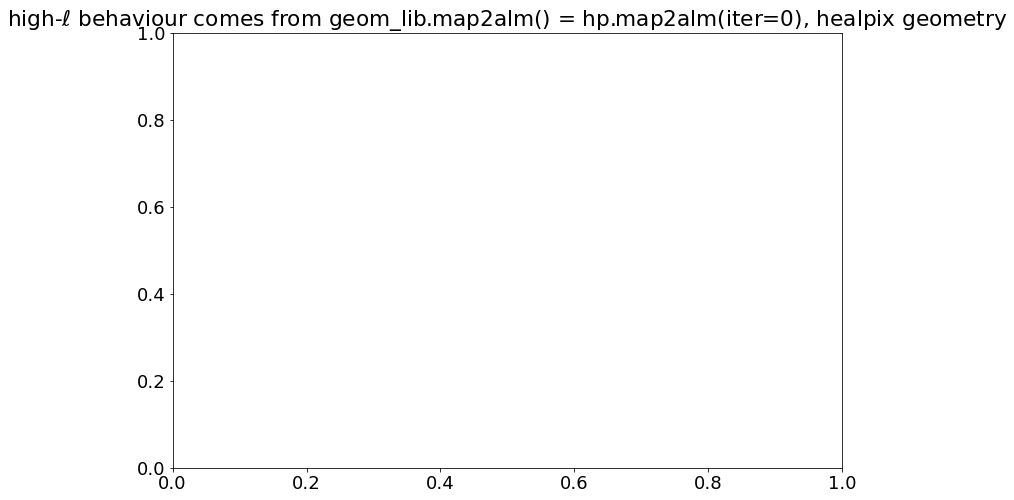

In [9]:
fig = plt.figure(figsize=(12,8))
ll = np.arange(0,lmax+1,1)
LL = np.arange(0,np.min([3*nside,lmax])+1,1)
scale_factor_l = (ll*(ll+1))/np.sqrt(2*np.pi)
scale_factor_L = (LL*(LL+1))**2/np.sqrt(2*np.pi)

geom_lib.init_transformer(lmax, mmax)

plt.title('high-$\ell$ behaviour comes from geom_lib.map2alm() = hp.map2alm(iter=0), healpix geometry')
plt.plot(scale_factor_l * hp.alm2cl(geom_lib.map2alm(np.copy(Tunl), lmax=lmax, mmax=lmax, nthreads=4)), label=r'$C_\ell^{TT, \rm{unl}}$')
# plt.plot(scale_factor_l * hp.alm2cl(geom_lib.map2alm(np.copy(EBunl[0]), lmax=lmax, mmax=lmax, nthreads=4)), label=r'$C_\ell^{EE, \rm{unl}}$')
# plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(EBunl[1]), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$C_\ell^{BB, \rm{unl}}$')

plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(Tsky), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$C_\ell^{TT, \rm{sky}}$')
# plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(EBsky[0]), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$\tilde{C}_\ell^{EE, \rm{sky}}$')
# plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(EBsky[1]), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$\tilde{C}_\ell^{BB, \rm{sky}}$')

plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(Tobs), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$C_\ell^{TT, \rm{obs}}$')
# plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(EBobs[0]), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
# plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(EBobs[1]), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')

plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(Tnoise), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$C_\ell^{TT, \rm{noise}}$')
# plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(EBnoise[0]), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$C_\ell^{EE, \rm{noise}}$', color='grey')
# plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(EBnoise[1]), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$C_\ell^{BB, \rm{noise}}$', color='grey')
plt.plot(scale_factor_L * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(phi), lmax=lmax, mmax=lmax, nthreads=4))*10**6), color='black', label=r'$C_L^{\phi\phi} \cdot 10^6$')

plt.legend()
plt.xlim(1,lmax+1024)
plt.ylim(1e-5,1e5)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

In [10]:
Tobs.shape

(4611072,)